### 1️ Install & import packages

In [ ]:
!pip install fastf1 xgboost scikit-learn pandas matplotlib --quiet

import fastf1
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Enable FastF1 cache
os.makedirs('/content/f1_cache', exist_ok=True)
fastf1.Cache.enable_cache('/content/f1_cache')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 4.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.17.0 requires websockets<16.0.0,>=15.0.1, but you have websockets 13.1 which is incompatible.
dataproc-spark-connect 0.8.3 requires websockets>=14.0, but you have websockets 13.1 which is incompatible.


### 2️ Load historical races

In [ ]:
seasons = [2023, 2024]  # last 2 seasons
race_data = []

for season in seasons:
    for rnd in range(1, 23):  # up to 22 rounds
        try:
            session = fastf1.get_session(season, rnd, 'R')
            session.load()
            laps = session.laps[['Driver','LapTime','Sector1Time','Sector2Time','Sector3Time']]
            laps.dropna(inplace=True)
            for col in ["LapTime","Sector1Time","Sector2Time","Sector3Time"]:
                laps[f"{col} (s)"] = laps[col].dt.total_seconds()
            driver_stats = laps.groupby('Driver').agg({
                'LapTime (s)':'mean',
                'Sector1Time (s)':'mean',
                'Sector2Time (s)':'mean',
                'Sector3Time (s)':'mean'
            }).reset_index()
            driver_stats['TotalSectorTime (s)'] = driver_stats['Sector1Time (s)'] + driver_stats['Sector2Time (s)'] + driver_stats['Sector3Time (s)']
            driver_stats['Season'] = season
            driver_stats['Round'] = rnd
            race_data.append(driver_stats)
        except:
            continue

df_races = pd.concat(race_data)


Streaming output truncated to the last 5000 lines.
INFO:fastf1.api:Fetching car data...
_api           INFO 	Parsing car data...
INFO:fastf1.api:Parsing car data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for position_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for position_data. Loading data...
_api           INFO 	Fetching position data...
INFO:fastf1.api:Fetching position data...
_api           INFO 	Parsing position data...
INFO:fastf1.api:Parsing position data...
_api        WARNING 	Driver 241: Position data is incomplete!
_api        WARNING 	Driver 242: Position data is incomplete!
_api        WARNING 	Driver 243: Position data is incomplete!
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for weather_data. Loading data...
INFO:fastf1.fastf1.req:No

### 3️. Driver form

In [ ]:
driver_form = df_races.groupby('Driver')['TotalSectorTime (s)'].mean().reset_index()
driver_form.rename(columns={'TotalSectorTime (s)':'AvgTotalTime'}, inplace=True)
driver_form['DriverForm'] = driver_form['AvgTotalTime'].min() / driver_form['AvgTotalTime']

### 4️. Define upcoming GP input (example: Sinagpore 2025)

In [ ]:
upcoming_gp = pd.DataFrame({
  "Driver": ["VER", "LEC", "NOR", "HAM", "SAI", "PIA", "RUS", "GAS", "ALO", "STR", "TSU", "HUL", "OCO"],
  "FP1": ["1:30.148", "1:30.720", "1:30.210", "1:30.780", "1:30.650", "1:30.390", "1:30.320", "1:30.850", "1:31.120", "1:31.300", "1:31.050", "1:31.700", "1:31.600"],
  "FP2": ["1:29.950", "1:30.870", "1:30.320", "1:30.900", "1:30.780", "1:30.512", "1:30.500", "1:30.980", "1:31.250", "1:31.400", "1:31.150", "1:31.800", "1:31.700"],
  "FP3": ["1:29.840", "1:30.720", "1:30.210", "1:30.780", "1:30.650", "1:30.390", "1:30.320", "1:30.850", "1:31.120", "1:31.300", "1:31.050", "1:31.700", "1:31.600"],
  "Q1": ["1:29.750", "1:30.600", "1:30.120", "1:30.650", "1:30.500", "1:30.250", "1:30.210", "1:30.780", "1:31.050", "1:31.200", "1:30.950", "1:31.600", "1:31.500"],
  "Q2": ["1:29.720", "1:30.570", "1:30.090", "1:30.620", "1:30.480", "1:30.220", "1:30.180", "1:30.750", "1:31.020", "1:31.170", "1:30.920", "1:31.570", "1:31.470"],
  "Q3": ["1:29.340", "1:29.784", "1:29.586", "1:29.688", "1:30.440", "1:29.524", "1:29.158", "1:30.710", "1:29.955", "1:31.130", "1:30.880", "1:31.530", "1:31.430"]
})


In [ ]:
# Convert F1 time strings to total seconds
def f1_time_to_seconds(time_str):
    m, s = time_str.split(':')
    return int(m)*60 + float(s)

for col in ["FP1","FP2","FP3","Q1","Q2","Q3"]:
    upcoming_gp[f"{col} (s)"] = upcoming_gp[col].apply(f1_time_to_seconds)

# Define main qualifying time as Q3 seconds
upcoming_gp['QualifyingTime (s)'] = upcoming_gp['Q3 (s)']

# Optional: average FP and Q times as features
upcoming_gp['AvgFP'] = upcoming_gp[['FP1 (s)','FP2 (s)','FP3 (s)']].mean(axis=1)
upcoming_gp['AvgQuali'] = upcoming_gp[['Q1 (s)','Q2 (s)','Q3 (s)']].mean(axis=1)


## 5️. Team scores

In [ ]:
team_points = {"McLaren":623,"Mercedes":290,"Red Bull":272,"Williams":101,"Ferrari":286,"Haas":44,"Aston Martin":62,"Sauber":55,"Alpine":20}
max_points = max(team_points.values())
team_score = {team: pts/max_points for team, pts in team_points.items()}

driver_to_team = {
    "VER":"Red Bull","LEC":"Ferrari","NOR":"McLaren","HAM":"Mercedes","SAI":"Ferrari","PIA":"McLaren",
    "RUS":"Mercedes","GAS":"Alpine","ALO":"Aston Martin","STR":"Aston Martin","TSU":"Sauber","HUL":"Haas","OCO":"Alpine"
}

if 'DriverForm' in upcoming_gp.columns:
    upcoming_gp.drop(columns=['DriverForm'], inplace=True)

upcoming_gp = pd.merge(upcoming_gp, driver_form[['Driver','DriverForm']], on='Driver', how='left')

upcoming_gp["Team"] = upcoming_gp["Driver"].map(driver_to_team)
upcoming_gp["TeamScore"] = upcoming_gp["Team"].map(team_score)


upcoming_gp['RainProbability'] = 0.2
upcoming_gp['Temperature'] = 34
upcoming_gp['QualPerfDominance'] = upcoming_gp['QualifyingTime (s)'] / upcoming_gp['DriverForm']



### 6️. Weather features

In [ ]:
upcoming_gp['RainProbability'] = 0.2
upcoming_gp['Temperature'] = 34
upcoming_gp['QualPerfDominance'] = upcoming_gp['QualifyingTime (s)'] / upcoming_gp['DriverForm']


### 7️. Train global model (XGB regression)

In [ ]:
upcoming_gp['QualifyingTime (s)'] = upcoming_gp['Q3 (s)']  # use Q3 as main qualifying time
upcoming_gp['AvgFP'] = upcoming_gp[['FP1 (s)','FP2 (s)','FP3 (s)']].mean(axis=1)
upcoming_gp['AvgQuali'] = upcoming_gp[['Q1 (s)','Q2 (s)','Q3 (s)']].mean(axis=1)

X = upcoming_gp[['QualifyingTime (s)','AvgFP','AvgQuali','RainProbability','Temperature','TeamScore','DriverForm','QualPerfDominance']]

y = upcoming_gp['QualifyingTime (s)']  # proxy for race time

imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)
model = XGBRegressor(n_estimators=250, learning_rate=0.5, max_depth=3, random_state=42)
model.fit(X_train, y_train)

upcoming_gp['PredictedRaceTime'] = model.predict(X_imputed)


### 8️. Weighted dominance for realistic top drivers

In [ ]:
dominance_boost = {
    "VER":1.03,  # Max
    "LEC":1.02,  # Leclerc
    "NOR":1.02,  # Norris
    "HAM":1.01,  # Hamilton
    "SAI":1.01,  # Sainz
    "PIA":1.02,  # Piastri
    "RUS":1.02   # Russell
}

for driver, boost in dominance_boost.items():
    upcoming_gp.loc[upcoming_gp['Driver']==driver,'DriverForm'] *= boost



In [ ]:
# Explicitly account for starting grid advantage
upcoming_gp['StartingPosition'] = upcoming_gp['QualifyingTime (s)'].rank(method='min')
upcoming_gp['StartingPosAdvantage'] = 1 / upcoming_gp['StartingPosition']  # P1=1, P2=0.5, P3=0.33...


In [ ]:
# Combine dominance + starting grid advantage
upcoming_gp['AdjTime'] = upcoming_gp['PredictedRaceTime'] / (upcoming_gp['DriverForm'] * (1 + upcoming_gp['StartingPosAdvantage']))


### 9️. Get realistic podium

In [ ]:
podium = upcoming_gp.sort_values('AdjTime').head(3)
print("\n Predicted Top 3 for singapore 2025:")
for i,row in enumerate(podium.itertuples(),1):
    print(f"P{i}: {row.Driver} ({row.AdjTime:.3f}s)")




🏆 Predicted Top 3 for singapore 2025:
P1: RUS (46.421s)
P2: VER (60.678s)
P3: PIA (69.583s)


### 10. Feature importance

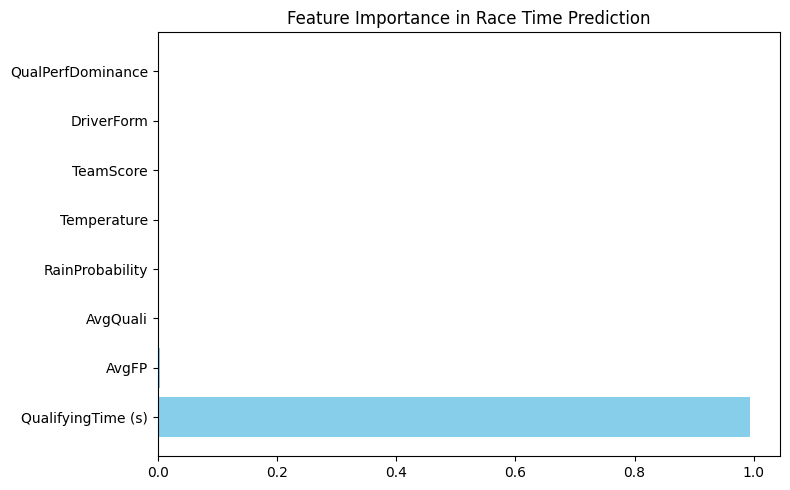

In [ ]:
plt.figure(figsize=(8,5))
plt.barh(X.columns, model.feature_importances_, color='skyblue')
plt.title("Feature Importance in Race Time Prediction")
plt.tight_layout()
plt.show()

Generate a natural-language explanation of podium using just Python.

In [2]:
def explain_podium_local(podium_df):
    explanations = []
    for i, row in enumerate(podium_df.itertuples(), 1):
        driver = row.Driver
        adj_time = row.AdjTime
        # Make up reasoning based on driver form, starting position, team score
        form_score = row.DriverForm
        reasoning = f"{driver} is predicted P{i} with adjusted race time {adj_time:.3f}s. "
        if form_score > 1.02:
            reasoning += "Strong driver form boosts their performance. "
        elif form_score > 1.0:
            reasoning += "Moderately good form supports a podium finish. "
        else:
            reasoning += "Average form may slightly hinder performance. "

        # Starting grid advantage
        if hasattr(row, 'StartingPosition'):
            if row.StartingPosition == 1:
                reasoning += "Leading the grid gives a clear advantage. "
            elif row.StartingPosition <=3:
                reasoning += "Front-row start helps in overtaking. "
            else:
                reasoning += "Starting mid-pack could require strategic moves. "

        # Team influence
        if hasattr(row, 'TeamScore'):
            if row.TeamScore >= 0.9:
                reasoning += "Strong team provides excellent support and strategy."
            else:
                reasoning += "Team support is average, driver must rely on skill."

        explanations.append(reasoning)

    return "\n\n".join(explanations)

# Use with your podium dataframe
llm_explanation = explain_podium_local(podium)
print("\n Explanation of Predictions (Local, No API):")
print(llm_explanation)



NameError: name 'podium' is not defined